In [1]:
import pandas as pd
import numpy as np
import modules
from scipy import signal
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from os.path import join, exists
from os import makedirs
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fftpack
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from sklearn.preprocessing import scale
import random
import librosa
from scipy import stats
from scipy.signal import hilbert, chirp
import peakutils
import plotly
plotly.tools.set_credentials_file(username='ashafi', api_key='PxONlbVA45fzeK3YWWb9')
from plotly.offline import iplot, init_notebook_mode
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import peakutils
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

/Users/alia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## functions Pearson

In [ ]:
def mycross_pearson(Stim, FFR):
    data = pd.DataFrame()
    cors = []
    lag = []
    for step in range(26 ,60):
        #         print(step)
        lag.append(step)
        mycross = scipy.stats.pearsonr(Stim, FFR[500+step:942+step])
        cors.append(mycross[0])
    data['lag'] = lag
    data['cor'] = cors
    return data

In [ ]:
def get_lags_pearson(el, dataStim, cmeta, chg):
    data = pd.DataFrame()
    elecs = [el]
    for e in elecs:
        correlations = []
        stims = []
        lags = []
        elec = []
        for s in dataStim:
            indx = np.where(cmeta['file'] == s[0:6])
            if len(indx[0]) >= 39:
                np.random.shuffle(indx)
                myhg = np.mean(chg[indx[0][0:39], :, e], axis=0)
                cor = mycross_pearson(dataStim[s], myhg)
                lag = np.where(cor['cor'] == max(cor['cor']))
                stims.append(s)
                correlations.append(cor['cor'][lag[0][0]])
                lags.append(cor['lag'][lag[0][0]])
                elec.append(e)
            else:
                pass

        data['lag'] = lags
        data['stim'] = stims
        data['correlations'] = correlations
        print('finished getting lags for elec: ' + str(el))

        return data

In [ ]:
def run_permute_pearson(stim, response, lag, iteration):
    print('running permutation')
    permutes = []
    mycross = scipy.stats.pearsonr(stim,response[500+lag:942+lag])
#     print(mycross[0])
    permutes.append(mycross[0])
    new_stim = stim.copy()
    for i in range(iteration):
        np.random.shuffle(new_stim)

        mycross = scipy.stats.pearsonr(new_stim,response[500+lag:942+lag])
        permutes.append(mycross[0])
    return permutes

## functions 2D correlation

In [2]:
def mycross(Stim, FFR):
    data = pd.DataFrame()
    cors = []
    lag = []
    for step in range(0 ,1):
        #         print(step)
        lag.append(step)
        f ,t, SSxx = signal.spectrogram(Stim, 1000, noverlap = 76, nperseg =90)
        ff ,ft, FSxx = scale_spec(FFR[500 +step: 942 +step])
#         plt.pcolormesh(ft, ff, FSxx, vmax=np.percentile(FSxx.flatten(), 99.9))
#         plt.title('scaled')
#         plt.show()
        
        mycross = scipy.signal.correlate2d(SSxx[8:, :] ,FSxx[8:, :], mode = 'valid')
#         mycross, _ = pearsonr(SSxx[5:,:].flatten(), FSxx[5:,:].flatten())
#         print('lag: ' + str(step) + ' cor' + str(mycross[0][0]))
        cors.append(mycross[0][0])
    data['lag'] = lag
    data['cor'] = cors
#     data['stim'] = stims


    return data


In [3]:
def get_lags(el, dataStim, cmeta, chg):
    data = pd.DataFrame()
    elecs = [el]
    for e in elecs:
        correlations = []
        stims = []
        lags = []
        elec = []
        for s in dataStim:
            indx = np.where(cmeta['file'] == s[0:6])
            if len(indx[0]) >= 39:
                np.random.shuffle(indx)
                myhg = np.mean(chg[indx[0][0:39], :, e], axis=0)
                cor = mycross(dataStim[s], myhg)
                lag = np.where(cor['cor'] == max(cor['cor']))
                stims.append(s)
                correlations.append(cor['cor'][lag[0][0]])
                lags.append(cor['lag'][lag[0][0]])
                elec.append(e)
            else:
                pass

        data['lag'] = lags
        data['stim'] = stims
        data['correlations'] = correlations
        print('finished getting lags for elec: ' + str(el))

        return data

In [4]:
def scale_spec(mydata):
    ## find the amplitude at each time bin
    myspec = np.fft.rfft(mydata)
    Amps = (np.linspace(0, 500, myspec.shape[0]), abs(myspec))
    #plt.plot(abs(myspec))

    ## calculate spec to get freq bin windows
    f, t, Sxx = signal.spectrogram(mydata, 1000, noverlap=76, nperseg=90)

    ## calculate freq bin
    freq_bins = []
    for i in range(len(f)):
        if i == 0:
            ls = list(range(0, int(f[i] + 5)))
            freq_bins.append(ls)
        else:
            ls = list(range(int(f[i] - 5), int(f[i] + 5)))
            freq_bins.append(ls)

    ## calculate the amp
    vals = []
    for t in freq_bins:
        if len(t) > 1:
            last = len(t)
            ind = np.where((Amps[0] > t[0]) & (Amps[0] < t[last - 1]))
            m = np.mean(Amps[1][ind[0]])
            vals.append(m)
        else:
            a = int(t[0])
            vals.append(Amps[1][a])

    ## put in df
    avg_amps = pd.DataFrame()
    avg_amps['bin#'] = list(range(46))
    avg_amps['feq_val'] = vals
#    plt.plot(np.linspace(0, 500, avg_amps['feq_val'].shape[0]), avg_amps['feq_val'])
#     print(avg_amps)
#    plt.title('avg vals and Spec')
    # plt.show()

    a, b, Sxx = signal.spectrogram(mydata, 1000, noverlap=76, nperseg=90)

    for v in range(len(vals)):
        for s in range(len(Sxx[v])):
            Sxx[v][s] = Sxx[v][s] / vals[v]

    return a, b, Sxx

In [ ]:
myspec = np.fft.rfft(myhg)
Amps = (np.linspace(0, 500, myspec.shape[0]), abs(myspec))
plt.plot(Amps[0],Amps[1])
plt.show()

In [ ]:
# f, t, Sxx = signal.spectrogram(dataStim['ma2-bN.wav'], 1000, noverlap=76, nperseg=90)
# plt.pcolormesh(t, f, Sxx, vmax=np.percentile(Sxx.flatten(), 90.9))
# plt.show()
# f

In [ ]:
# a,b,new = scale_spec(myhg)
# plt.pcolormesh(b, a, new, vmax=np.percentile(new.flatten(), 99.9))
# plt.show()

In [5]:
def run_permute_shuffle_stimwav(stim, response, lag, iteration):
    print('running permutation')
    permutes = []
    sf, st, SSxx = signal.spectrogram(stim, 1000, noverlap=76, nperseg=90)
    ff, ft, FSxx = scale_spec(response[500 + lag:942 + lag])
    mycross = signal.correlate2d(FSxx[8:, :], SSxx[8:, :], mode='valid')

    permutes.append(mycross[0][0])
    new_Stim = stim.copy()

    for i in range(iteration):
        np.random.shuffle(new_Stim)
        fq, time, newS = signal.spectrogram(new_Stim, 1000, noverlap=76, nperseg=90)
        mycross = signal.correlate2d(FSxx[8:, :], newS[8:, :], mode='valid')
        permutes.append(mycross[0][0])   

        
#         plt.subplot(1, 2, 1)
#         plt.pcolormesh(ft, ff, FSxx, vmax=np.percentile(FSxx.flatten(), 99.9))
#         plt.title('response')
#         plt.subplot(1, 2, 2)
#         plt.pcolormesh(st, sf, new_Sxx, vmax=np.percentile(SSxx.flatten(), 99.9))
#         plt.title('stim')
#         plt.show()
    return permutes

In [ ]:
new_Stim = Sxx.copy()
flatten_stim = new_Stim.flatten()
np.random.shuffle(flatten_stim)
reshape_stim = np.reshape(flatten_stim, (46,26))
mycross = signal.correlate2d(FSxx[8:, :], reshape_stim[8:, :], mode='valid')



In [6]:
def run_permute_shuffle_spec(stim, response, lag, iteration):
    print('running permutation')
    permutes = []
    sf, st, SSxx = signal.spectrogram(stim, 1000, noverlap=76, nperseg=90)
    ff, ft, FSxx = scale_spec(response[500 + lag:942 + lag])
    mycross = signal.correlate2d(FSxx[8:, :], SSxx[8:, :], mode='valid')

    permutes.append(mycross[0][0])
    new_Stim = SSxx.copy()
    flatten_stim = new_Stim.flatten()
    for i in range(iteration):
        np.random.shuffle(flatten_stim)
        reshape_stim = np.reshape(flatten_stim, (46,26))
        mycross = signal.correlate2d(FSxx[8:, :], reshape_stim[8:, :], mode='valid')
        permutes.append(mycross[0][0])   

        
#         plt.subplot(1, 2, 1)
#         plt.pcolormesh(ft, ff, FSxx, vmax=np.percentile(FSxx.flatten(), 99.9))
#         plt.title('response')
#         plt.subplot(1, 2, 2)
#         plt.pcolormesh(st, sf, new_Sxx, vmax=np.percentile(SSxx.flatten(), 99.9))
#         plt.title('stim')
#         plt.show()
    return permutes

In [7]:
def run_permute(stim, response, lag, iteration):
    print('running permutation')
    permutes = []
    sf, st, SSxx = signal.spectrogram(stim, 1000, noverlap=76, nperseg=90)
    ff, ft, FSxx = scale_spec(response[500 + lag:942 + lag])
#     mycross = signal.correlate2d(SSxx[5:, :], FSxx[5:, :], mode='valid')
    mycross, _ = pearsonr(SSxx[5:,:].flatten(), FSxx[5:,:].flatten())
#     print(mycross[0][0])
    permutes.append(mycross)
    new_Sxx = SSxx.copy()

    for i in range(iteration):
        for z in new_Sxx:
            np.random.shuffle(z)
#         plt.subplot(1, 2, 1)
#         plt.pcolormesh(ft, ff, FSxx, vmax=np.percentile(FSxx.flatten(), 99.9))
#         plt.title('response')
#         plt.subplot(1, 2, 2)
#         plt.pcolormesh(st, sf, new_Sxx, vmax=np.percentile(SSxx.flatten(), 99.9))
#         plt.title('stim')
#         plt.show()
        mycross = signal.correlate2d(FSxx[8:, :], new_Sxx[8:, :], mode='valid')
#         mycross, _ = pearsonr(FSxx[5:,:].flatten(), new_Sxx[5:,:].flatten())
        permutes.append(mycross)
    return permutes

In [ ]:
## plot all elec perms 
iterplot = 0
for i in range(24):
    plt.subplot(6,4,iterplot)
    run_permute()

In [ ]:
indx = np.where(cmeta['file'] == 'ma4-bN')
myhg = np.mean(chg[indx[0], :, 32],axis = 0)

ff ,ft, FSxx = scale_spec(myhg)
plt.subplot(1, 2, 1)
plt.pcolormesh(ft, ff, FSxx, vmax=np.percentile(FSxx.flatten(), 99.9))
plt.title('scaled')
plt.subplot(1, 2, 2)
f ,t, SSxx = signal.spectrogram(myhg, 1000, noverlap = 76, nperseg =90)
plt.pcolormesh(t, f, SSxx, vmax=np.percentile(SSxx.flatten(), 99.9))
plt.show()


## Read Data

In [8]:
# load the data
datafile = '/Users/alia/Documents/mandarin/UI399/data/UI399_LFP_1kHz.h5'
f = h5py.File(datafile, "r")
hg = f['hg'].value
bad_channels = f['hg'].attrs['bad_channels']
f.close()
meta = pd.read_hdf(datafile)

In [9]:
# to get rid of "bad" trials (just one here)
meta['Trial'] = range(0, meta.shape[0])
good_idx = np.where(meta['HG'])[0]
chg = hg[good_idx, :, :].copy()
cmeta = meta.loc[np.where(meta['HG'])[0]].copy().reset_index(drop = True)

In [10]:
## add 'file' column in cmeta
cmeta['file'] = np.zeros(len(cmeta))
for l in range(len(cmeta)):
    cmeta['file'][l] = cmeta['syllable'][l] + str(cmeta['tone'][l]) + '-' + cmeta['speaker'][l] + "N"

/Users/alia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/alia/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



###### Read in already permuted data and stat values

In [11]:
homeDir = ('/Users/alia/Documents/mandarin/final_zscore_all.csv')
PThresh = pd.read_csv(homeDir,index_col=None, header=0, encoding = "ISO-8859-1")

## Read in Stim

In [12]:
'''this reads each wav file, zero pads it to match the FFR, runs autocorr on all stimuli and then 
    normalizing from -1 to 1'''
import scipy.io
import os

'''autocorr the stimulation wav files t = tone, p = b or h, male or female'''
dirs = os.listdir('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/')
dataStim = pd.DataFrame()
positive = np.zeros((558,))
negative = np.zeros((500,))


for i in dirs:
    y, sr= librosa.load('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/' + i, sr = 1000)
#     y = np.append(y,positive)
#     y = np.insert(y,0,negative)
    dataStim[i] = y

## run tests

In [ ]:
from modules import scale_spec
from modules import get_lag
from modules import run_permute

In [ ]:
cmeta.loc[indx]

In [ ]:
t.shape

In [24]:
def plot_FFR(e,stim):
    EL = e
    myfile = stim
    indx = np.where(cmeta['file'] ==myfile[:6])
    myhg = np.mean(chg[indx[0], :,EL],axis = 0)
    ff ,ft, FSxx = scale_spec(myhg[500:1000])
    return ff,ft,FSxx

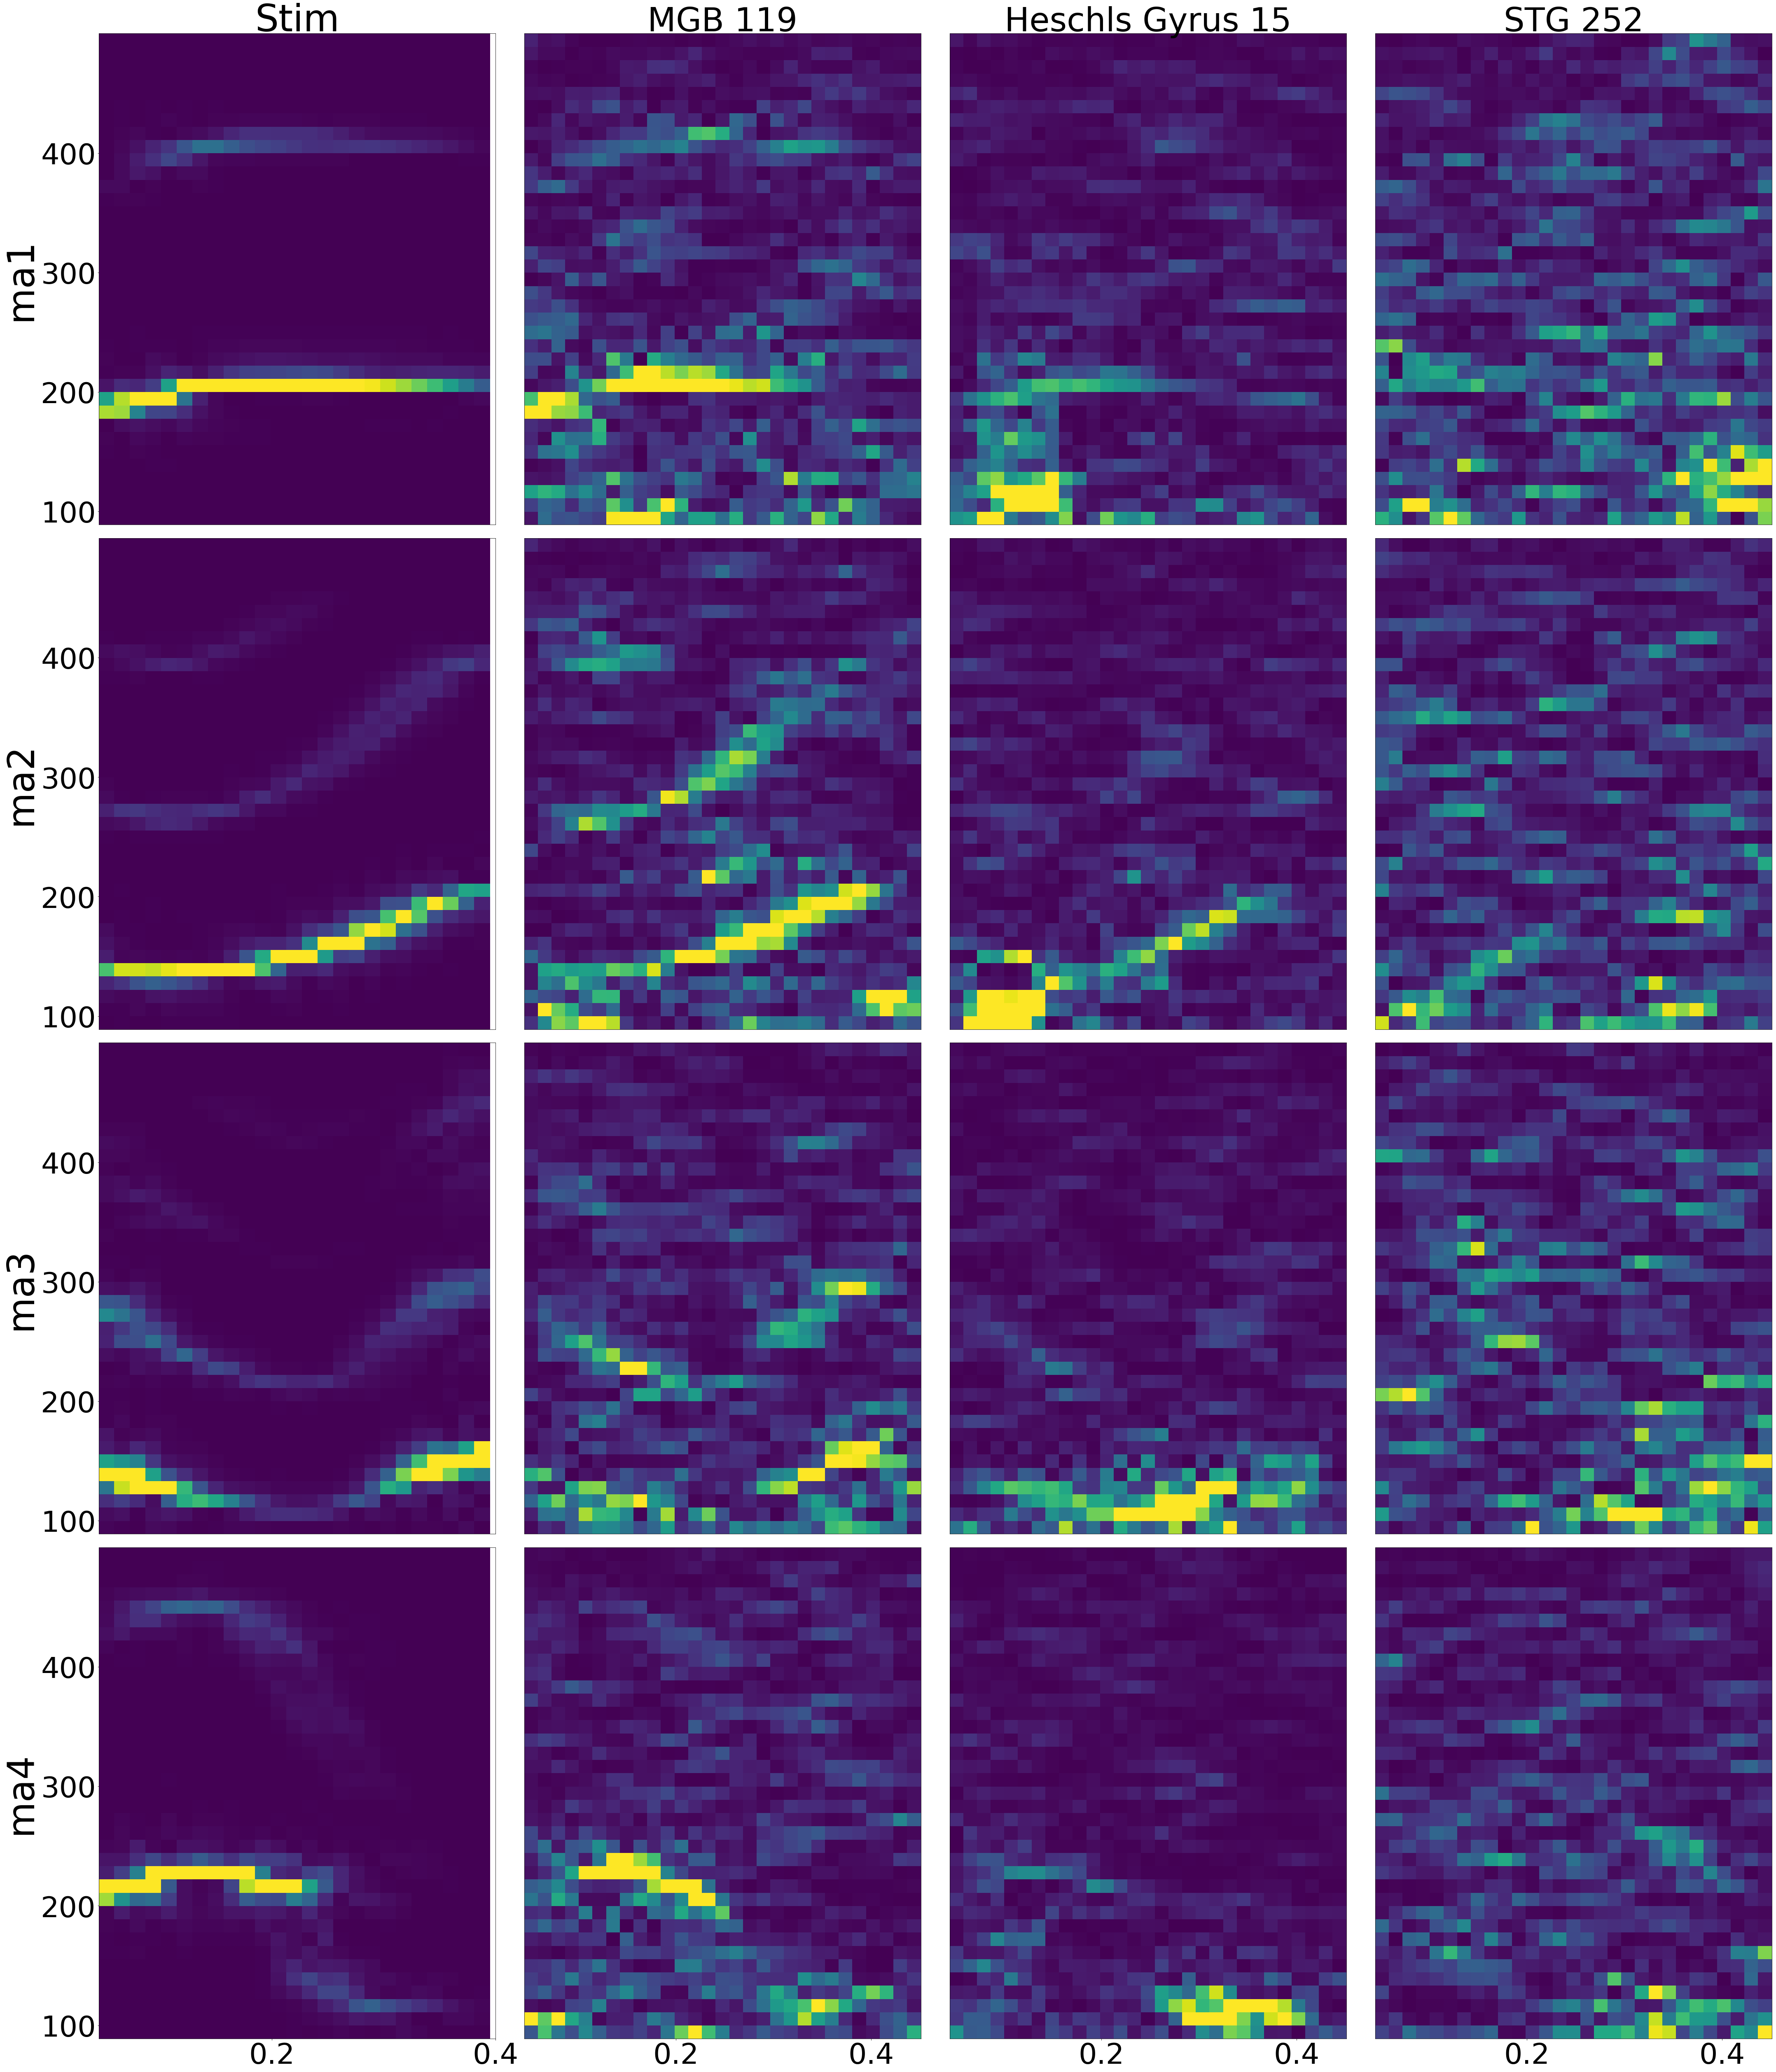

In [77]:
iterplot = 1
figure = plt.figure(figsize = (60,70))
stims = ['ma1-bN.wav', 'ma2-bN.wav','ma3-bN.wav','ma4-bN.wav']
for s in stims:

##Stim
    plt.subplot(4, 4, iterplot)
    sf, st, SSxx = signal.spectrogram(dataStim[s], 1000, noverlap=76, nperseg=90)
    plt.pcolormesh(st, sf[8:], SSxx[8:, :], vmax=np.percentile(SSxx.flatten(), 98.9))
    plt.xticks(np.arange(.2, .5, .2),size = 70)
    plt.yticks(np.arange(100, 500, 100),size = 70)
    if iterplot == 1:
        plt.title('Stim',size = 90)
    if iterplot in [1,5,9,13]:
        plt.ylabel(s[0:3],size = 90, rotation = 90)
    if 13<= iterplot <=16:
        plt.xticks(np.arange(.2, .5, .2),size = 70)
    else:
        plt.xticks(np.arange(0,0,1),size = 70)




    
    iterplot+=1
##MG    
    plt.subplot(4, 4, iterplot)
    ff ,ft, FSxx = plot_FFR(119,s)
    plt.pcolormesh(ft, ff[8:], FSxx[8:, :], vmax=np.percentile(FSxx.flatten(), 95.9))
    if iterplot <=4:
        plt.title('MGB ' + str(119), size = 80)
    if 13<= iterplot <=16:
        plt.xticks(np.arange(.2, .5, .2),size = 70)
    else:
        plt.xticks(np.arange(0,0,1),size = 70)
    plt.yticks(np.arange(0,0,1),size = 70)
    iterplot+=1   


    plt.subplot(4, 4, iterplot)
    x,y,z = plot_FFR(15,s)
    plt.pcolormesh(y, x[8:], z[8:, :], vmax=np.percentile(z.flatten(), 95.9))
    if iterplot <=4:
        plt.title('Heschls Gyrus ' + str(15), size = 80)
    plt.yticks(np.arange(0,0,1),size = 70)
    plt.xticks(np.arange(.2, .5, .2),size = 70)
    if 13<= iterplot <=16:
        plt.xticks(np.arange(.2, .5, .2),size = 70)
    else:
        plt.xticks(np.arange(0,0,1),size = 70)
    
    
    
    iterplot+=1


    plt.subplot(4, 4, iterplot) 
    
    
    a,b,c = plot_FFR(252,s)
    plt.pcolormesh(b, a[8:], c[8:, :], vmax=np.percentile(c.flatten(), 95.9))
    
    plt.yticks(np.arange(0,0,1),size = 70)

    plt.xticks(np.arange(.2, .5, .2),size = 70)
    if iterplot <=4:
        plt.title('STG ' + str(252), size = 80)
    if 13<= iterplot <=16:
        plt.xticks(np.arange(.2, .5, .2),size = 70)
    else:
        plt.xticks(np.arange(0,0,1),size = 70)
    iterplot+=1




################# di







plt.tight_layout()
plt.show()
figure.savefig("foo4.pdf", bbox_inches='tight')



In [ ]:
all_lags = pd.DataFrame()
for e in range(1):
    data = get_lag.get_lags(e, dataStim, cmeta, chg)
    all_lags.append(data)
    

In [ ]:
cor =1.738978e-06

In [ ]:
test = run_permute(dataStim['di4-hN.wav'], myhg,26, 10000 )


In [ ]:
z = scipy.stats.zscore(test)
print(z[0])
plt.plot(test)
plt.show()

## Run permutation

In [ ]:
elecs = list(range(256))
# elecs = [253,245,237,219,220,221,212,213,204,205,206,196,197,198,189,190,181,182,173,174,13,14,15,16,17,18,19,20,21,22,23,32,33,34,35,36,37,38,39, 119, 120,121,122,123,124]
# elecs = [222,229]
# PThresh = pd.DataFrame()
thresh = []
elec = []
stim = []
c = []
z = []
PVal = []

for e in elecs:
#     stim = []
#     c = []
    boxplotData = pd.DataFrame()
#     figure = plt.figure(figsize = (30,20))
    iterplot = 1
    print(str(e) + ' is starting')
    data = get_lags(e, dataStim, cmeta, chg)
    for s in dataStim:
        indx = np.where(cmeta['file'] == s[0:6])
        if len(indx[0]) == 0:
            pass
#             print(s)
        else:
            myhg = np.mean(chg[indx[0], :, e],axis = 0)
        for d in range(len(data)):
            if data['stim'][d] == s:
                
                stim.append(s)
                lag = data['lag'][d]
                cors = data['correlations'][d]
                p = run_permute_shuffle_spec(dataStim[s], myhg, lag,10000)
#                 print(p)
#                 plt.subplot(4,6,iterplot)
                boxplotData[s] = p[1:]
#                 plt.hist(p[1:],10)
#                 plt.xticks(size = 20, rotation = 90)
#                 plt.yticks(size = 20)
#                 plt.title(s, size = 20)
#                 plt.plot([p[0],p[0]],[0,10])
#                 iterplot+=1
                
                
                t = np.percentile(p[1:],95)
                
                
#                 p.append(cors)##appending the highest cor with optimal lag to the permutations
#                 zscore = scipy.stats.zscore(p)#run z score on p
                zscore = (p[0] - np.mean(p[1:]))/np.std(p[1:])
                pval = scipy.stats.percentileofscore(p[1:],p[0]) ## this gives a percentage of p that is below cors
                
                PVal.append(pval)
                z.append(zscore) #grab the last value zscore because that is related to the p
                
                
                
                elec.append(e)
        
        
                thresh.append(t)
                c.append(cors)
#     sns.boxplot(data = boxplotData)
#     plt.title(e, size = 30)
#     plt.xticks(rotation = 90, size = 20)
#     plt.yticks(size = 20)
#     plt.scatter(stim,c, color = 'r')
#     print(data = boxplotData)
    plt.show()



In [ ]:
elecs = [253,245,237,219,220,221,212,213,204,205,206,196,197,198,189,190,181,182,173,174,13,14,15,16,17,18,19,20,21,22,23,32,33,34,35,36,37,38,39, 119, 120,121,122,123,124]

In [ ]:
plt.figure(figsize=(30,20))
save = np.where(PThresh['stim'] == 'di1-hN.wav')
points = []
test = []
for i in save[0]:
    points.append(i)
    test.append(PThresh['orig'][i])
plt.plot(PThresh['zscore'], alpha = .5)
plt.scatter(points, test, color ='r')
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.title('correlation values for every stim and HG&STG elecs, red dots correspond to di4-hN correlation values', size = 30)
plt.show()

In [ ]:
th = .05/24
# p = th/24
# zscore = (p - np.mean(PThresh['pval']))/np.std(PThresh['pval'])
th

In [ ]:
from scipy.stats import pearsonr

In [ ]:
PThresh = pd.DataFrame()

In [ ]:
PThresh['elec'] = elec
PThresh['stim'] = stim
PThresh['thresh'] = thresh
PThresh['orig'] = c
PThresh['pval'] = PVal
PThresh['zscore'] = z

In [ ]:
add = pd.DataFrame()
add['elec'] = elec
add['stim'] = stim
add['thresh'] = thresh
add['orig'] = c
add['pval'] = PVal
add['zscore'] = z

In [ ]:
PThresh = PThresh.append(add)

In [ ]:
PThresh.to_csv('final_zscore_all.csv')

In [ ]:
## save output
PThresh.to_csv('method1.csv')

In [ ]:
for p in range(len(PThresh['stim'])):
    PThresh['stim'][p] = PThresh['stim'][p][0:5]

In [ ]:
 PThresh['stim'][1][0:5]

In [ ]:
new_PT = pd.DataFrame()
new_PT['elec'] = PThresh['elec']
new_PT['zscore'] = PThresh['zscore']

In [ ]:
elecs = list(range(256))

In [ ]:
max_zs = pd.DataFrame()
mz = []
# elecs = [222,229]
for el in elecs:
    zs = []
    for a in range(len(new_PT)):
        if el == new_PT['elec'][a]:
            zs.append(new_PT['zscore'][a])
    mz.append(max(zs))
    
max_zs['elec'] = elecs
max_zs['zscore'] = mz
            
    

In [ ]:
max_zs.to_csv('max_zscores.csv')

## Make Heatmap

In [ ]:
data = pd.DataFrame()
data['elec'] = PThresh['elec']
data['stim'] = PThresh['stim']
data['zscore'] = PThresh['zscore']

In [ ]:
d = []
new = [d.append((100-a)/100) for a in PThresh['pval']]
data['pval'] = new

In [ ]:
from statsmodels.stats.multitest import fdrcorrection
is_significant, new_p_values = fdrcorrection(d, alpha = 0.05)
new_p_values = new_p_values.reshape(data['pval'].shape)

data['pval'] = new_p_values.tolist()

In [ ]:
# plt.plot(PThresh['orig'])
# plt.show()

In [ ]:
## get rid of non sig values
for z in range(len(data)):
    if data['pval'][z] >.05:
        data['zscore'][z] = np.nan

In [ ]:
data =data.pivot_table(index=['stim'],columns=['elec'],values='zscore')

## Organize by speaker then by tone

In [ ]:
t = np.unique(PThresh['stim'])
tone1h = []
tone2h = []
tone3h = []
tone4h = []
tone1b = []
tone2b = []
tone3b = []
tone4b = []
for s in t:
    if 'b' in s[3:6]:
        if '1' in s:
            tone1b.append(s[0:5])

        if '2' in s:
            tone2b.append(s[0:5])

        if '3' in s:
            tone3b.append(s[0:5])

        if '4' in s:
            tone4b.append(s[0:5])
    if 'h' in s[3:6]:
        if '1' in s:
            tone1h.append(s[0:5])

        if '2' in s:
            tone2h.append(s[0:5])

        if '3' in s:
            tone3h.append(s[0:5])

        if '4' in s:
            tone4h.append(s[0:5])

## Organize by tone

In [ ]:
t = np.unique(PThresh['stim'])
tone1 = []
tone2 = []
tone3 = []
tone4 = []
for s in t:
    if '1' in s:
        tone1.append(s)

    if '2' in s:
        tone2.append(s)

    if '3' in s:
        tone3.append(s)

    if '4' in s:
        tone4.append(s)




## organize by syllable

In [ ]:
t = np.unique(PThresh['stim'])
ma = []
di = []
bu = []

for s in t:
    if 'ma' in s:
        ma.append(s)

    if 'di' in s:
        di.append(s)

    if 'bu' in s:
        bu.append(s)

            

##### Reindex Data 

In [ ]:
## new index to order in tones
ls = [tone1b,tone2b,tone3b,tone4b,tone1h,tone2h,tone3h,tone4h]
# ls = [tone1,tone2,tone3,tone4]
# ls = [ma,di,bu]
flat_list = [item for sublist in ls for item in sublist]
data = data.reindex(flat_list)

In [ ]:
253,245,237,299,220,221,212,213,204,205,206,196,197,198,189,190,181,182,173,174

In [ ]:
# [166,165,164,174,173,172,182,181,180,190,189,188,198,197,196,206,205,204,214,213,212,221,220,222,228,229,230,237,236,245,244,253,252,13,14,15,32,33,16,34,17,35,18,36,19,37,20,38,21,22,23,119,120,121]

In [ ]:
## reindex by elecs
# STG_elecs = [164,172,180,181,182, 188,189,190,196,197,198,204,205,206,213,214,221,228,229,236,244,252,253]
STG_elecs = [166,165,164,174,173,172,182,181,180,190,189,188,198,197,196,206,205,204,214,213,212,221,220,222,228,229,230,237,236,245,244,253,252]
HG_elecs = [13,14,15,32,33,16,34,17,35,18,36,19,37,20,38,21,22,23]
Hipp = [119,120,121]

In [ ]:
# STG_elecs.reverse()


In [ ]:
new_labels = []
new_labels.append(Hipp)
new_labels.append(HG_elecs)
new_labels.append(STG_elecs)
reind = [item for sublist in new_labels for item in sublist]



In [ ]:
# data

In [ ]:
new_2 = data.reindex(columns = reind)

In [ ]:
from numpy import arange
sns.set(font_scale=1)
x = arange(25).reshape(5, 5)
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)

In [ ]:
import seaborn
figure = plt.figure(figsize = (60,40))
plt.xticks(size = 40)
plt.yticks(size = 70)
sns.set(font_scale=5)
seaborn.heatmap(new_2, cmap = 'Reds', vmin = 3.89, vmax = 16)
# plt.imshow(data, cmap = 'Reds', vmin = 2.3, vmax = np.max(data.flatten()))
# plt.xlabel('elecs', size = 40)
# plt.ylabel('stim', size = 40)
plt.legend(loc=0, fontsize=30, font = 'bold')
# plt.title('Method 1 with 3.89 thresholding')
plt.tight_layout()
plt.show()
figure.savefig("HeatMap.pdf", bbox_inches='tight')

In [ ]:
data

In [ ]:
plt.hist(PThresh['zscore']*100000,20)
plt.show()

In [ ]:
PThresh